# Assignment 1 - Computational Psycholinguistics
By Daan Brugmans

## 1. Imports and Seed

In [7]:
import os
import itertools

import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from tqdm import tqdm

SEED = 3131

## 2. Data Loading

In [96]:
PATH_TO_EXPERIMENT_DATA = os.path.join(os.getcwd(), "data", "data_naming.csv")
PATH_TO_TRAIN_DATA = os.path.join(os.getcwd(), "data", "train_en.txt")
MODEL_DIR = os.path.join(os.getcwd(), "models")

test_df = pd.read_csv(PATH_TO_EXPERIMENT_DATA)
test_df = test_df.replace("unrel_strong", "unrel")
test_df = test_df.replace("unrel_weak", "unrel")

display(test_df)

,isi,prime,target,condition,meanRT
0,50,capability,ability,strong,580.5
1,1050,capability,ability,strong,577.4
2,50,means,ability,weak,538.0
3,1050,means,ability,weak,571.0
4,50,fuel,ability,unrel,639.3
...,...,...,...,...,...
11035,1050,giraffe,zoo,weak,545.4
11036,50,crisp,zoo,unrel,542.8
11037,1050,crisp,zoo,unrel,685.2
11038,50,bottle,zoo,unrel,545.6


## 3. Model Training
If you want to run this notebook, you do not need to train, the models, since the pre-trained models will be loaded later.

In [97]:
WORD2VEC_VECTOR_SIZE = 300
WORD2VEC_MIN_COUNT = 5
WORD2VEC_EPOCHS = 5
WORD2VEC_WORKERS = 2

WORD2VEC_SG_SPACE = {0, 1}
WORD2VEC_WINDOW_SPACE = {2, 5, 8}
WORD2VEC_SEARCH_SPACE = itertools.product(WORD2VEC_SG_SPACE, WORD2VEC_WINDOW_SPACE)

for architecture, window_size in tqdm(WORD2VEC_SEARCH_SPACE):
    if architecture == 0:
        architecture_name = "cbow"
    elif architecture == 1:
        architecture_name = "skipgram"
    else:
        raise ValueError("Invalid value of sg encountered:", architecture, ", was of type", type(architecture))
    
    word2vec_model = Word2Vec(
        corpus_file=PATH_TO_TRAIN_DATA,
        sg=architecture,
        window=window_size,
        vector_size=WORD2VEC_VECTOR_SIZE,
        min_count=WORD2VEC_MIN_COUNT,
        epochs=WORD2VEC_EPOCHS,
        seed=SEED,
        workers=WORD2VEC_WORKERS
    )
    
    path_to_word2vec_model = os.path.join(MODEL_DIR, f"{architecture_name}_window_{window_size}.word2vec")
    word2vec_model.save(path_to_word2vec_model)

0it [00:00, ?it/s]

0it [00:03, ?it/s]


KeyboardInterrupt: 

## 4. Model Loading

In [16]:
cbow_window_2 = Word2Vec.load(os.path.join(MODEL_DIR, "cbow_window_2.word2vec"))
cbow_window_5 = Word2Vec.load(os.path.join(MODEL_DIR, "cbow_window_5.word2vec"))
cbow_window_8 = Word2Vec.load(os.path.join(MODEL_DIR, "cbow_window_8.word2vec"))

skipgram_window_2 = Word2Vec.load(os.path.join(MODEL_DIR, "skipgram_window_2.word2vec"))
skipgram_window_5 = Word2Vec.load(os.path.join(MODEL_DIR, "skipgram_window_5.word2vec"))
skipgram_window_8 = Word2Vec.load(os.path.join(MODEL_DIR, "skipgram_window_8.word2vec"))

## 5. Model Testing

In [216]:
# TODO: For every word2vec model, calculate the cosine similarities between test_df prime and target using `model.wv.similarity(prime, target)`

# TODO: Store the cosine similarities, group by semantic relatedness (strong, weak, unrelated) and calculate the mean.per group.
# Check if mean similarities match the three conditions: strong should be largest (since small semantic distance/large semantic similarity), then weak, then unrelated

# TODO: Investigate how well the sizes of the priming effects for each target are predicted by cosine similarities
# Build seaborn regression plot where x = cosine_similarity, y = meanRT, col = isi, seed = SEED
# Use SciPy to get linear regression slope, intercept, r from seaborn plot and add it to plot

def calculate_cosine_similarities(row: pd.Series, word2vec_model: Word2Vec) -> float:
    model_vocabulary = list(word2vec_model.wv.index_to_key) # NOTE: Instruction from assignment (model.wv.vocab) does not work in Gensim 4.0.0
    
    if row["prime"] not in model_vocabulary:
        return 0.0
    
    if row["target"] not in model_vocabulary:
        return 0.0
    
    return word2vec_model.wv.similarity(row["prime"], row["target"])

def print_mean_cosine_similarity_by_semantic_relatedness(df: pd.DataFrame, similarity_column_name: str) -> None:
    strong_mean = df[df["condition"] == "strong"][similarity_column_name].mean()
    weak_mean = df[df["condition"] == "weak"][similarity_column_name].mean()
    unrel_mean = df[df["condition"] == "unrel"][similarity_column_name].mean()
    
    print(f"Mean Cosine Similarities by Semantic Relatedness using {similarity_column_name}:")
    print(f"    Strong: {strong_mean}")
    print(f"    Weak: {weak_mean}")
    print(f"    Unrelated: {unrel_mean}")
    
def plot_cosine_similarity_as_predictor_of_priming_effect(df: pd.DataFrame, similarity_column_name: str) -> None:
    plot = sns.lmplot(x=similarity_column_name, y="meanRT", col="condition", data=df, seed=SEED, line_kws={"color": "C1"})
    
    for indices, facet_df in plot.facet_data():
        reg_slope, reg_intercept, r, _, _ = scipy.stats.linregress(
            x=facet_df[similarity_column_name],
            y=facet_df["meanRT"]
        )
        
        plt.text(-3 + (indices[1] * 1.38), 1000, f"y = {round(reg_slope, 2)}x + {round(reg_intercept)}")
        plt.text(-3 + (indices[1] * 1.38), 975, f"r = {round(r, 3)}")

### 5.1 CBOW Window 2

Mean Cosine Similarities by Semantic Relatedness using cbow_2_cosine:
    Strong: 0.409881381788696
    Weak: 0.2997494748952137
    Unrelated: 0.07716377347408696


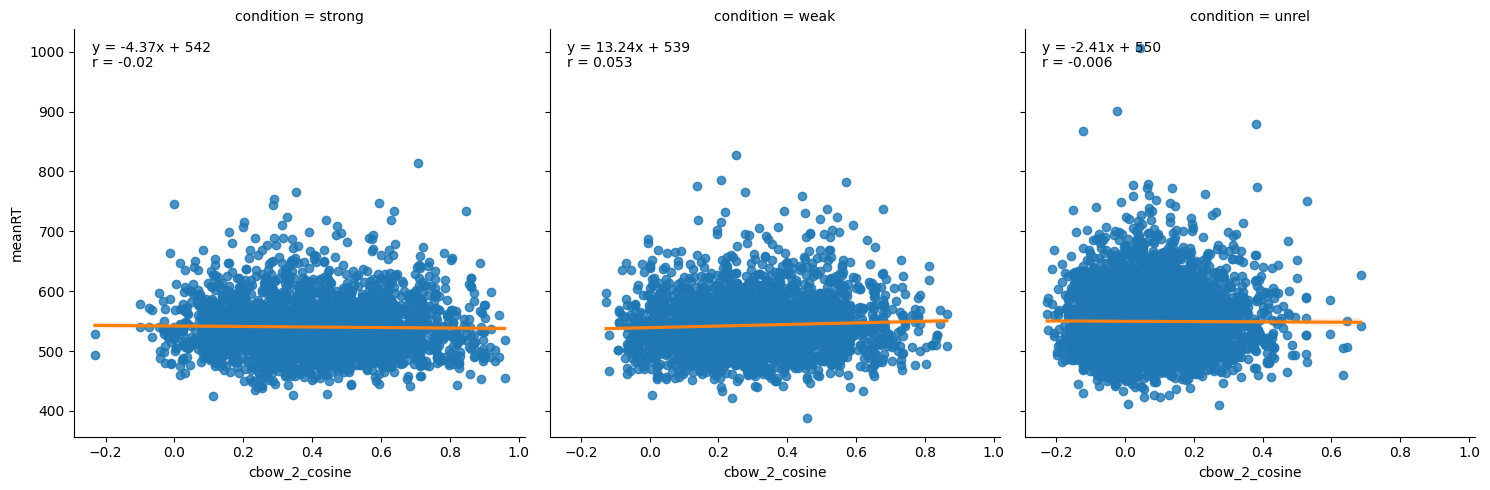

In [217]:
test_df["cbow_2_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=cbow_window_2, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "cbow_2_cosine")

plot_cosine_similarity_as_predictor_of_priming_effect(test_df, "cbow_2_cosine")

### 5.2 CBOW Window 5

Mean Cosine Similarities by Semantic Relatedness using cbow_5_cosine:
    Strong: 0.4162317159413563
    Weak: 0.30492301575592345
    Unrelated: 0.06981662859935844


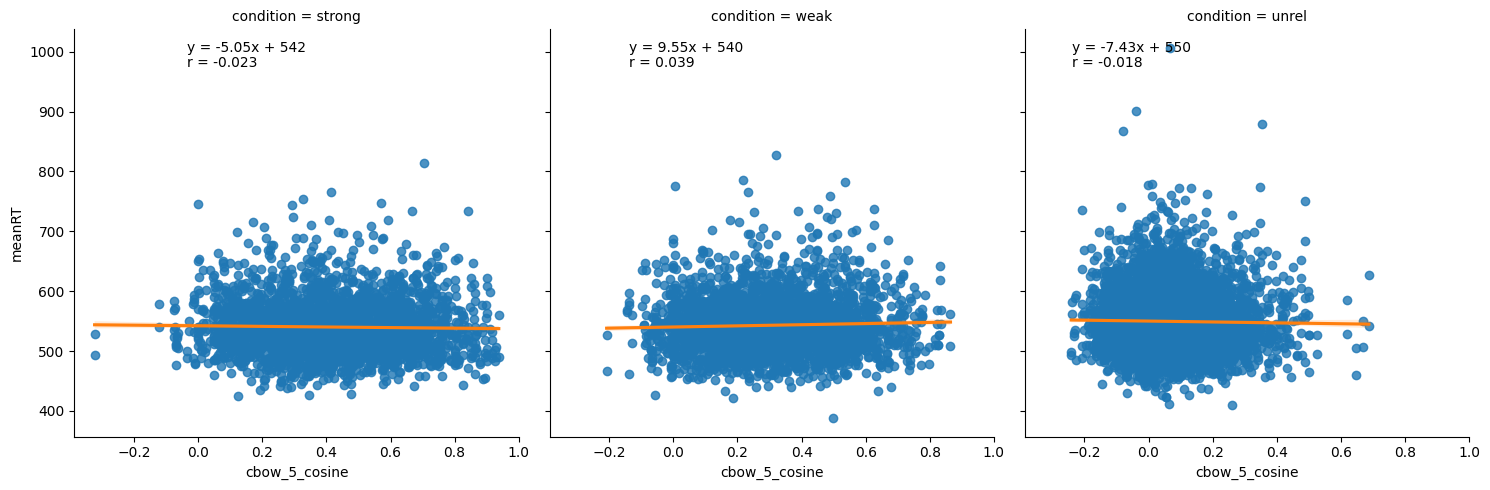

In [218]:
test_df["cbow_5_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=cbow_window_5, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "cbow_5_cosine")

plot_cosine_similarity_as_predictor_of_priming_effect(test_df, "cbow_5_cosine")

### 5.3 CBOW Window 8

Mean Cosine Similarities by Semantic Relatedness using cbow_8_cosine:
    Strong: 0.41480248304239165
    Weak: 0.3044206501738897
    Unrelated: 0.06484616057024549


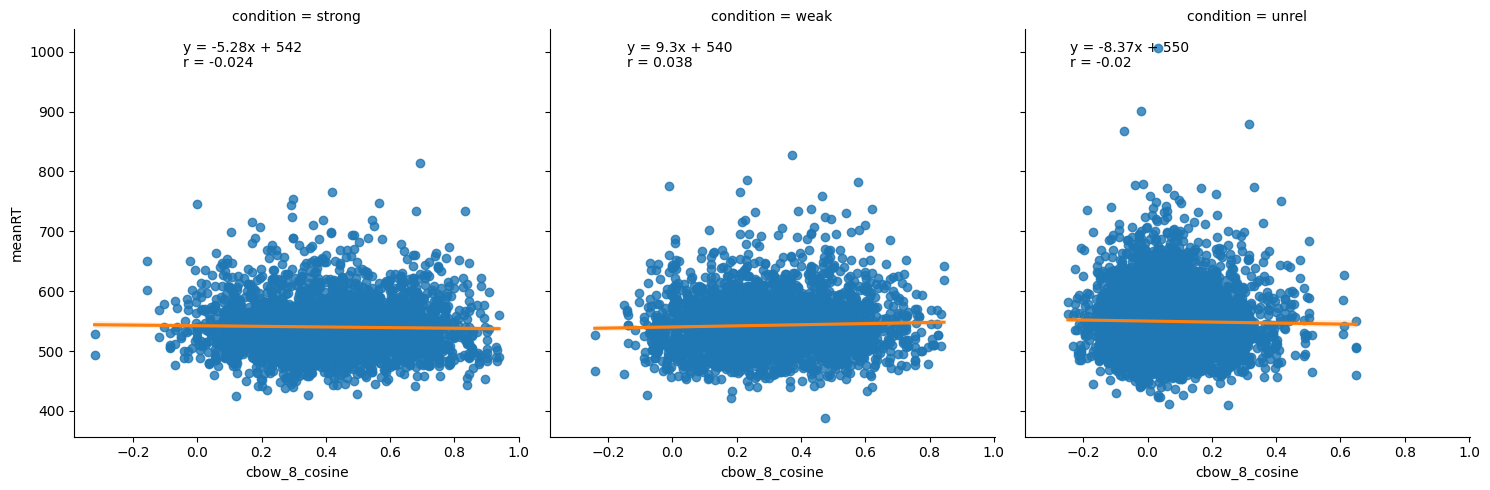

In [219]:
test_df["cbow_8_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=cbow_window_8, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "cbow_8_cosine")

plot_cosine_similarity_as_predictor_of_priming_effect(test_df, "cbow_8_cosine")

### 5.4 Skip-Gram Window 2

Mean Cosine Similarities by Semantic Relatedness using skipgram_2_cosine:
    Strong: 0.3972847288973002
    Weak: 0.2968085164586386
    Unrelated: 0.11298818337915256


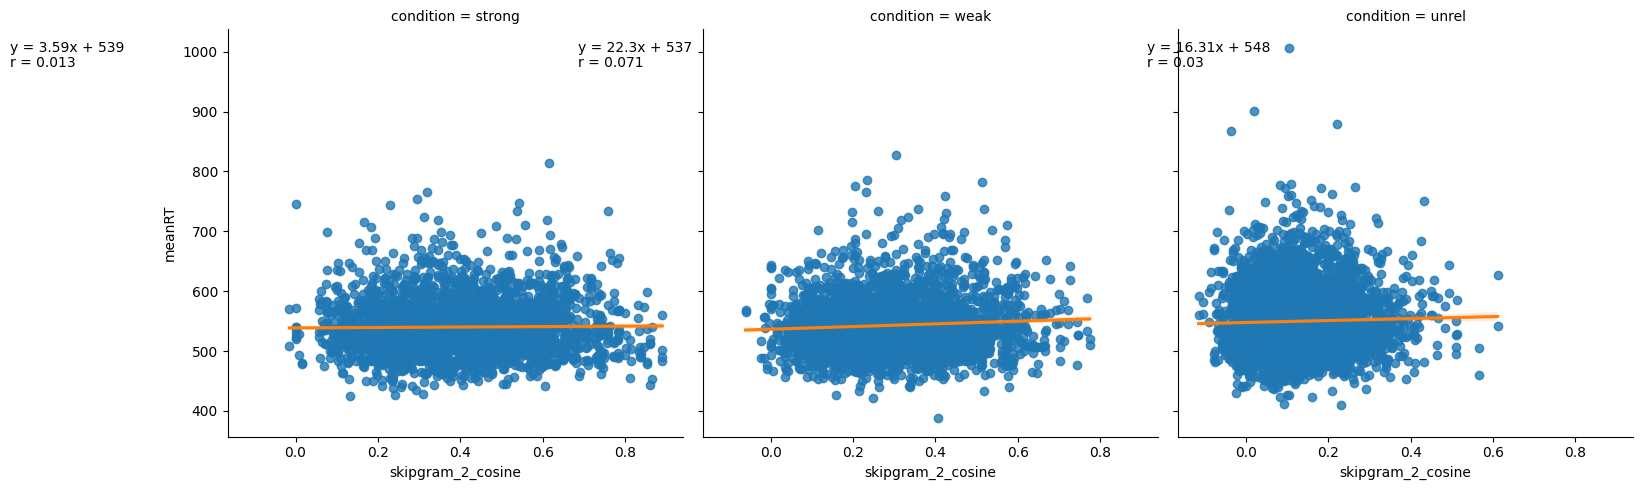

In [220]:
test_df["skipgram_2_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=skipgram_window_2, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "skipgram_2_cosine")

plot_cosine_similarity_as_predictor_of_priming_effect(test_df, "skipgram_2_cosine")

### 5.5 Skip-Gram Window 5

Mean Cosine Similarities by Semantic Relatedness using skipgram_5_cosine:
    Strong: 0.40953222510701826
    Weak: 0.3067186014601907
    Unrelated: 0.1050422957540466


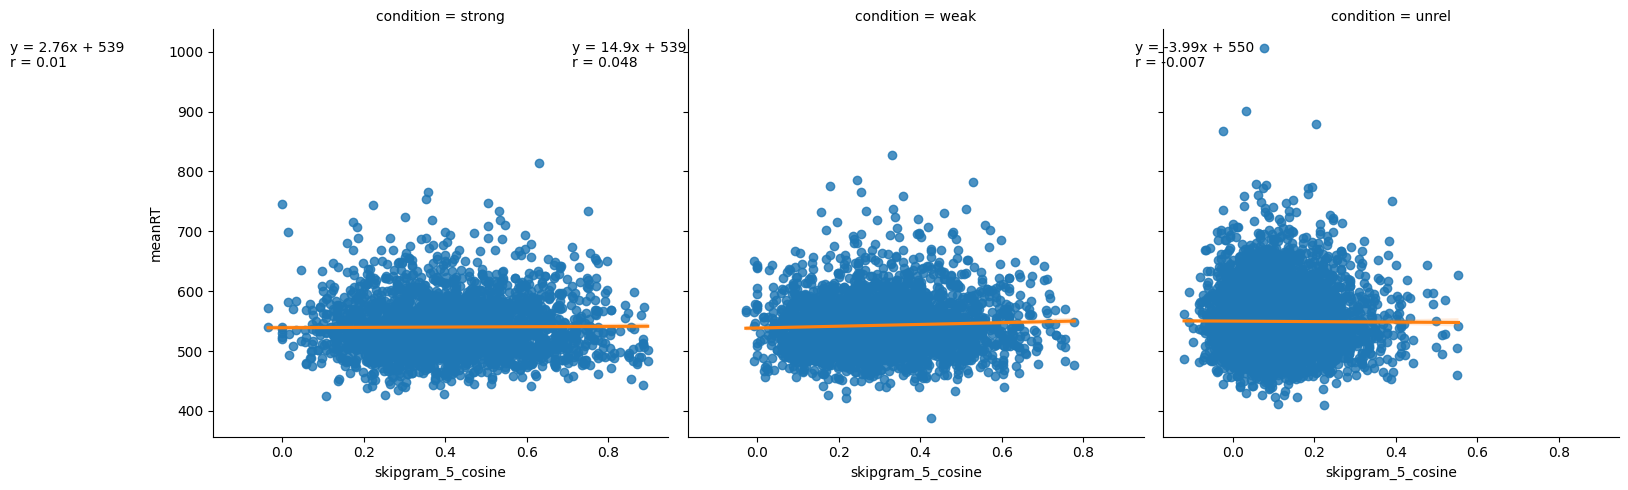

In [221]:
test_df["skipgram_5_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=skipgram_window_5, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "skipgram_5_cosine")

plot_cosine_similarity_as_predictor_of_priming_effect(test_df, "skipgram_5_cosine")

### 5.6 Skip-Gram Window 8

Mean Cosine Similarities by Semantic Relatedness using skipgram_8_cosine:
    Strong: 0.4170220403837553
    Weak: 0.31366485754796475
    Unrelated: 0.10707668869690151


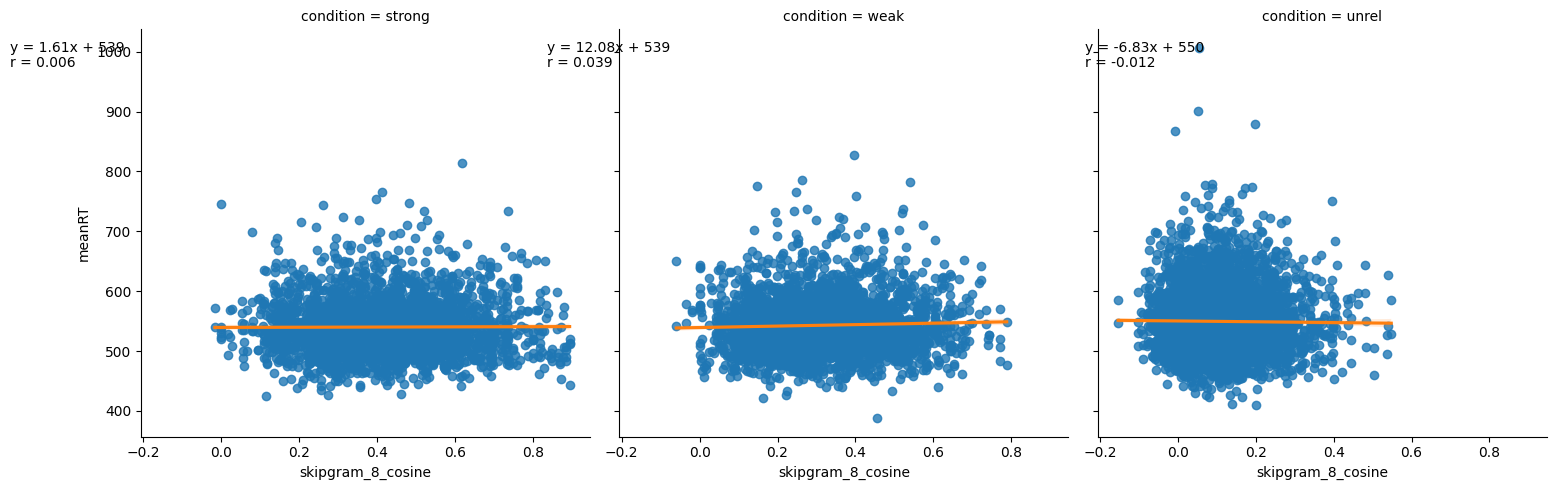

In [222]:
test_df["skipgram_8_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=skipgram_window_8, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "skipgram_8_cosine")

plot_cosine_similarity_as_predictor_of_priming_effect(test_df, "skipgram_8_cosine")